In [1]:
!pip install git+https://github.com/huggingface/trl.git
!pip install -U bitsandbytes
!pip install ipywidgets
!pip install python-dotenv
!pip install -U peft
!pip install matplotlib
!pip install seaborn
!pip install wordcloud

  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-4k92o86l
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-4k92o86l
  Resolved https://github.com/huggingface/trl.git to commit c10cc8995b6fd45f3a876ec98cade97251abe733
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login
from dotenv import load_dotenv
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

In [3]:
load_dotenv()

True

In [4]:
hf_tkn = os.getenv("HF_TOKEN")
login(token=hf_tkn)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
!huggingface-cli whoami

revanthkumar1999


In [139]:
mdl_id = "google/gemma-2b"
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [140]:
tok = AutoTokenizer.from_pretrained(mdl_id)
mdl = AutoModelForCausalLM.from_pretrained(
    mdl_id,
    quantization_config=bnb_cfg,
    device_map={"": 0}
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [141]:
# **Initial Testing Before Training**
print("Testing the model with initial examples (before fine-tuning):")
init_examples = [
    "Translate the following Telugu to English: జీవితంలో సంతోషం పొందడం ఎలా? ఒక రెండు మాటల్లో చెప్పు.",
    "Translate the following Telugu to English: మంచి ఆరోగ్యం కోసం ఏమి చేయాలి?",
]

dev = "cuda:0"
for i, txt in enumerate(init_examples, 1):
    tok_inp = tok(txt, return_tensors="pt", truncation=True, padding=True).to(dev)
    gen_out = mdl.generate(**tok_inp, max_new_tokens=50)
    init_trans_out = tok.decode(gen_out[0], skip_special_tokens=True)
    print(f"Initial Example {i}:")
    print(f"Input: {txt}")
    print(f"Initial Output: {init_trans_out}\n")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Testing the model with initial examples (before fine-tuning):
Initial Example 1:
Input: Translate the following Telugu to English: జీవితంలో సంతోషం పొందడం ఎలా? ఒక రెండు మాటల్లో చెప్పు.
Initial Output: Translate the following Telugu to English: జీవితంలో సంతోషం పొందడం ఎలా? ఒక రెండు మాటల్లో చెప్పు.

Answer:

Step 1/2
1. How to get happiness in life? - One way to get happiness in life is to be grateful. - Another way to get happiness in life is to be kind to others.

Step 

Initial Example 2:
Input: Translate the following Telugu to English: మంచి ఆరోగ్యం కోసం ఏమి చేయాలి?
Initial Output: Translate the following Telugu to English: మంచి ఆరోగ్యం కోసం ఏమి చేయాలి?

Answer:

Step 1/2
1. మంచి ఆరోగ్యం కోసం ఏమి చేయాలి?

Step 2/2
2. Translate the Telugu to English: What should I do for good



In [142]:
# Dataset loading
data = load_dataset("Telugu-LLM-Labs/telugu_alpaca_yahma_cleaned_filtered_romanized")

In [143]:
import re

def clean_text(text):
    text = re.sub(r'[^\w\s.,!?]', '', text)  # Keeps letters, numbers, and basic punctuation
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing spaces
    return text.strip().lower()

def select_fields(dat):
    # Clean the Telugu and English fields
    te_text = dat["telugu_instruction"].strip()  # Remove leading/trailing whitespace for Telugu
    en_text = clean_text(dat["instruction"])  # Apply cleaning function to English
    
    return {"te": te_text, "en": en_text}


In [144]:
# Map and filter the dataset
data = data.map(select_fields, remove_columns=data["train"].column_names)

In [145]:
ds["train"] = data["train"].select(range(min(10000, len(data["train"]))))

In [146]:
ds

DatasetDict({
    train: Dataset({
        features: ['te', 'en'],
        num_rows: 10000
    })
})

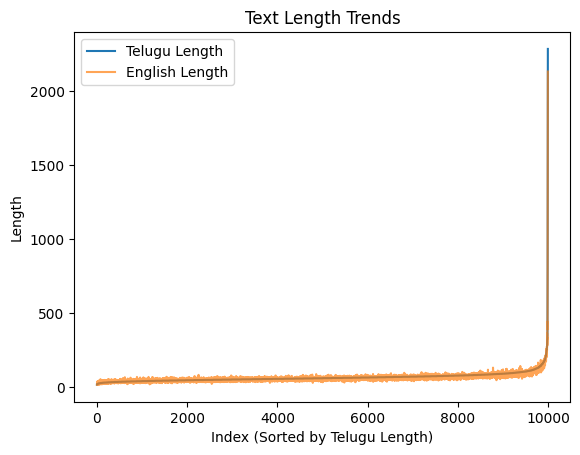

In [147]:
def visualize_line_plot():
    lang_data = pd.DataFrame(ds["train"])
    lang_data["length_te"] = lang_data["te"].apply(len)
    lang_data["length_en"] = lang_data["en"].apply(len)

    lang_data = lang_data.sort_values("length_te")  # Sort by Telugu text length
    plt.plot(lang_data["length_te"].values, label="Telugu Length")
    plt.plot(lang_data["length_en"].values, label="English Length", alpha=0.7)
    plt.title("Text Length Trends")
    plt.xlabel("Index (Sorted by Telugu Length)")
    plt.ylabel("Length")
    plt.legend()
    plt.show()

visualize_line_plot()

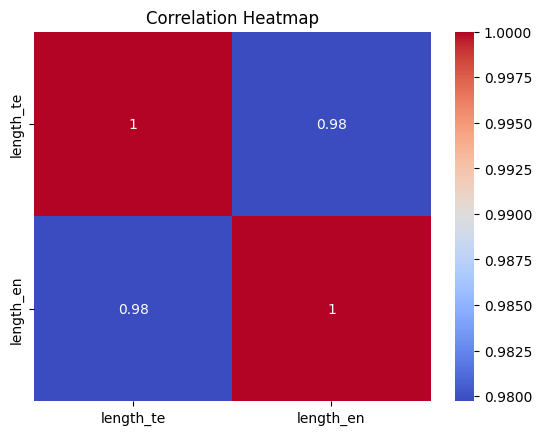

In [148]:
def visualize_heatmap():
    lang_data = pd.DataFrame(ds["train"])
    lang_data["length_te"] = lang_data["te"].apply(len)
    lang_data["length_en"] = lang_data["en"].apply(len)

    correlation_matrix = lang_data[["length_te", "length_en"]].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

visualize_heatmap()

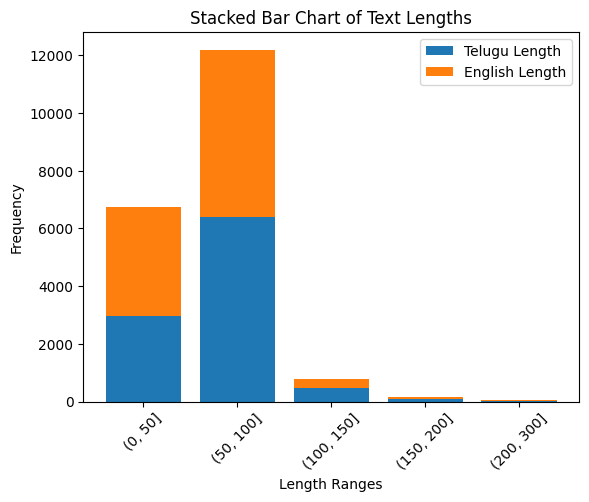

In [149]:
def visualize_stacked_bar():
    lang_data = pd.DataFrame(ds["train"])
    lang_data["length_te"] = lang_data["te"].apply(len)
    lang_data["length_en"] = lang_data["en"].apply(len)

    bins = [0, 50, 100, 150, 200, 300]
    te_bins = pd.cut(lang_data["length_te"], bins).value_counts().sort_index()
    en_bins = pd.cut(lang_data["length_en"], bins).value_counts().sort_index()

    plt.bar(te_bins.index.astype(str), te_bins, label="Telugu Length")
    plt.bar(en_bins.index.astype(str), en_bins, bottom=te_bins, label="English Length")
    plt.xticks(rotation=45)
    plt.title("Stacked Bar Chart of Text Lengths")
    plt.xlabel("Length Ranges")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

visualize_stacked_bar()

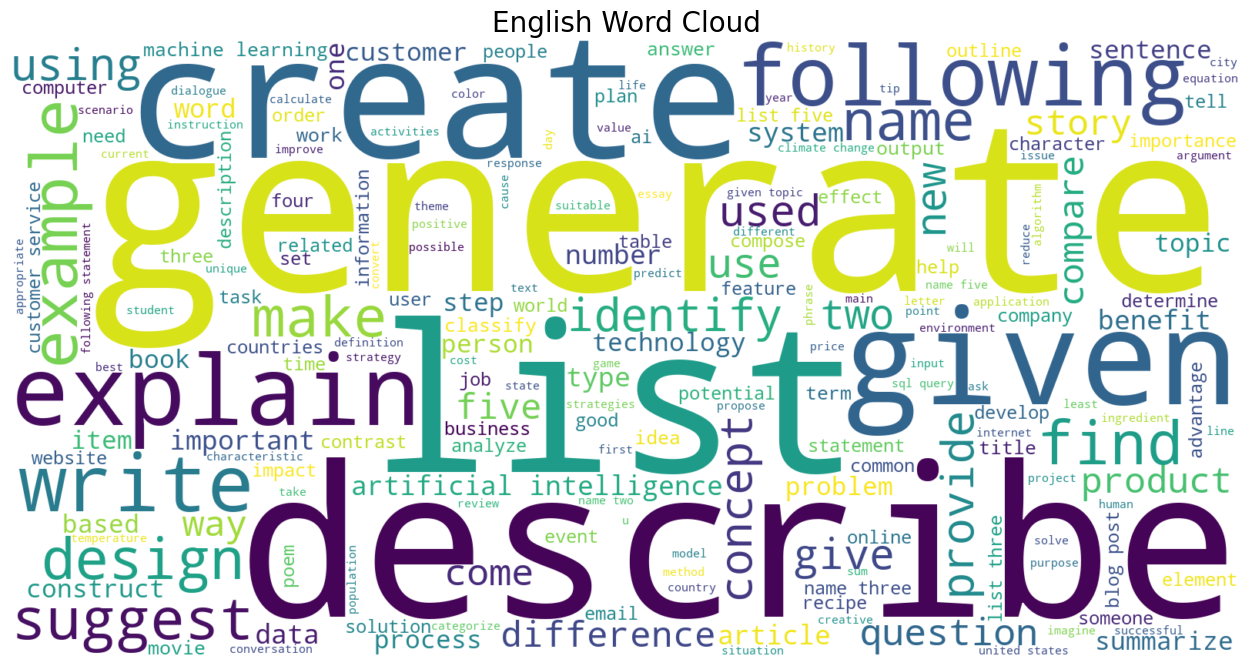

In [150]:
def visualize_wordcloud():
    lang_data = pd.DataFrame(ds["train"])
    english_text = " ".join(lang_data["en"])

    # Generate the word cloud
    english_wc = WordCloud(width=1600, height=800, background_color="white").generate(english_text)

    # Display the word cloud
    plt.figure(figsize=(16, 8))  # Larger figure size
    plt.imshow(english_wc, interpolation="bilinear")
    plt.title("English Word Cloud", fontsize=20)
    plt.axis("off")
    plt.show()

visualize_wordcloud()

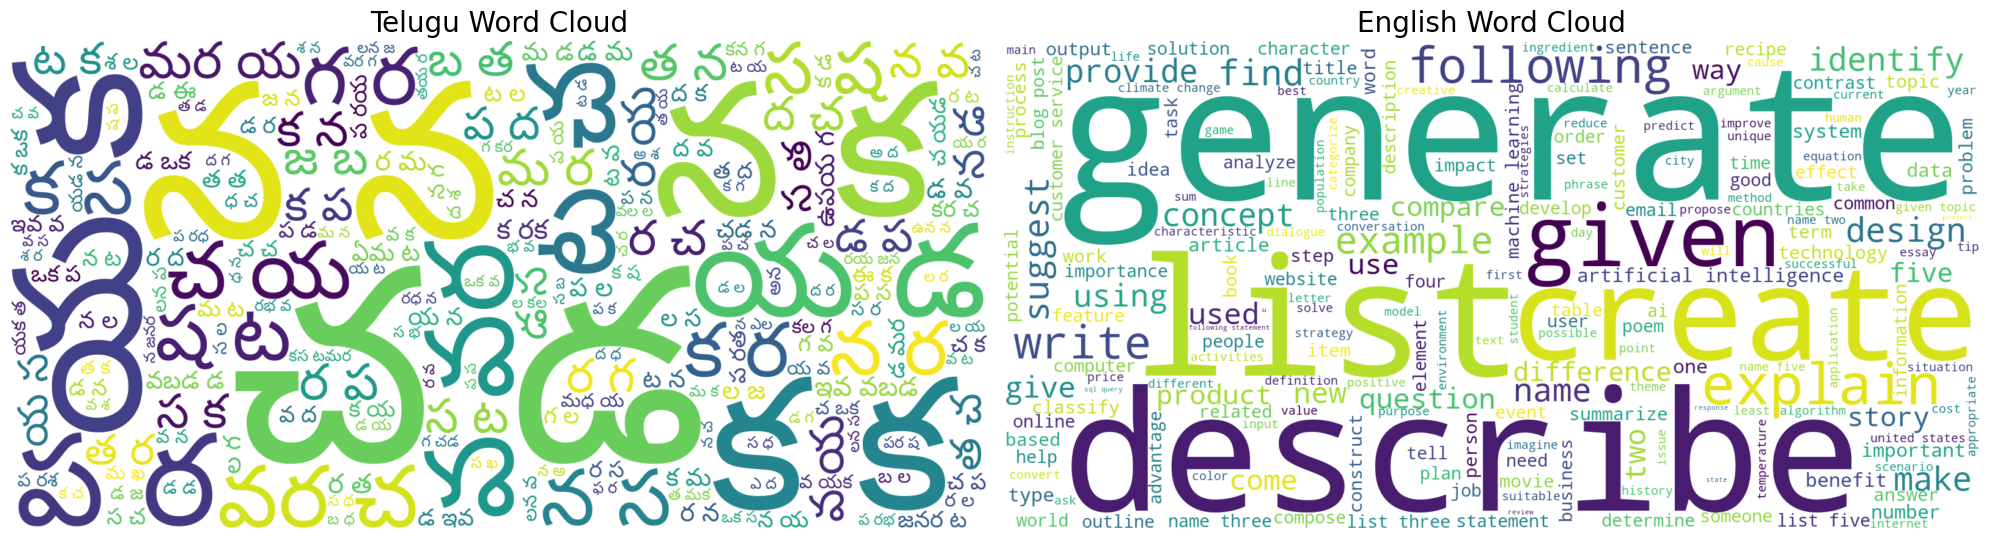

In [151]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

def visualize_wordclouds():
    lang_data = pd.DataFrame(ds["train"])
    
    # Combine text for Telugu and English
    telugu_text = " ".join(lang_data["te"])
    english_text = " ".join(lang_data["en"])

    # Path to a Telugu-compatible font (update this to the correct path)
    telugu_font_path = "NotoSansTelugu-Regular.ttf"  # Replace with the path to your font file

    # Generate word clouds
    telugu_wc = WordCloud(width=1600, height=800, background_color="white", font_path=telugu_font_path).generate(telugu_text)
    english_wc = WordCloud(width=1600, height=800, background_color="white").generate(english_text)

    # Display word clouds side by side
    plt.figure(figsize=(20, 10))

    # Telugu Word Cloud
    plt.subplot(1, 2, 1)
    plt.imshow(telugu_wc, interpolation="bilinear")
    plt.title("Telugu Word Cloud", fontsize=20)
    plt.axis("off")

    # English Word Cloud
    plt.subplot(1, 2, 2)
    plt.imshow(english_wc, interpolation="bilinear")
    plt.title("English Word Cloud", fontsize=20)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_wordclouds()

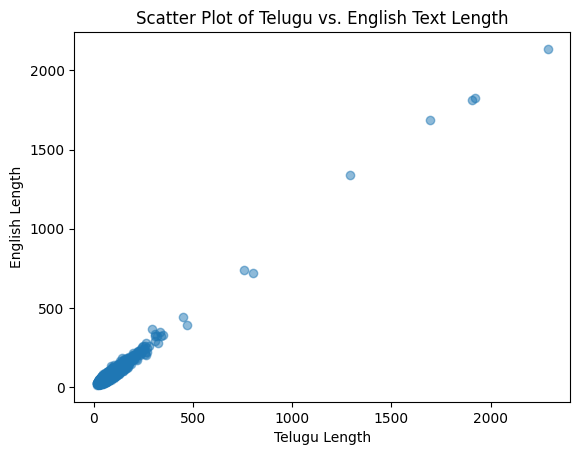

In [152]:
def visualize_scatter():
    lang_data = pd.DataFrame(ds["train"])
    lang_data["length_te"] = lang_data["te"].apply(len)
    lang_data["length_en"] = lang_data["en"].apply(len)

    plt.scatter(lang_data["length_te"], lang_data["length_en"], alpha=0.5)
    plt.title("Scatter Plot of Telugu vs. English Text Length")
    plt.xlabel("Telugu Length")
    plt.ylabel("English Length")
    plt.show()

visualize_scatter()


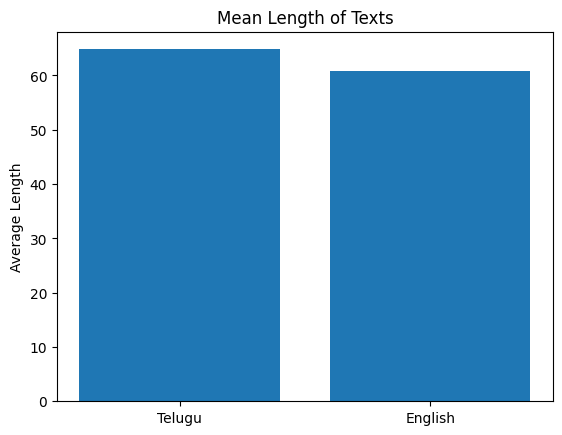

In [153]:
def visualize_barplot():
    lang_data = pd.DataFrame(ds["train"])
    lang_data["length_te"] = lang_data["te"].apply(len)
    lang_data["length_en"] = lang_data["en"].apply(len)

    mean_lengths = [lang_data["length_te"].mean(), lang_data["length_en"].mean()]
    plt.bar(["Telugu", "English"], mean_lengths)
    plt.title("Mean Length of Texts")
    plt.ylabel("Average Length")
    plt.show()

visualize_barplot()


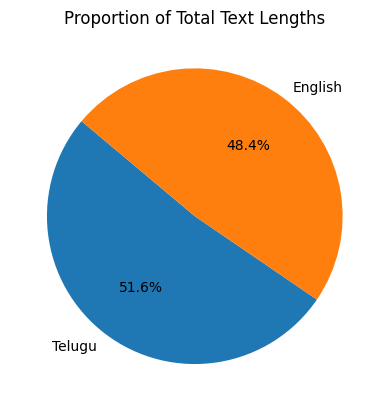

In [154]:
def visualize_piechart():
    lang_data = pd.DataFrame(ds["train"])
    lang_data["length_te"] = lang_data["te"].apply(len)
    lang_data["length_en"] = lang_data["en"].apply(len)

    total_lengths = [lang_data["length_te"].sum(), lang_data["length_en"].sum()]
    plt.pie(total_lengths, labels=["Telugu", "English"], autopct="%1.1f%%", startangle=140)
    plt.title("Proportion of Total Text Lengths")
    plt.show()

visualize_piechart()


In [155]:
ds

DatasetDict({
    train: Dataset({
        features: ['te', 'en'],
        num_rows: 10000
    })
})

In [156]:
lora_cfg = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

In [157]:
mdl = get_peft_model(mdl, lora_cfg)

In [158]:
def formatting_func(example):
    telugu_text = example['te'][0].strip()
    english_text = example['en'][0].strip().lower()
    
    text = f"translate the following telugu to english: {telugu_text} | english: {english_text} <eos>"
    return [text]

In [163]:
# Provide the training arguments
sft_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=12,
    gradient_accumulation_steps=8,
    warmup_steps=20,
    max_steps=100,
    learning_rate=1e-4,
    weight_decay=0.005,
    fp16=True,
    logging_steps=10,
    output_dir="outputs",
    optim="paged_adamw_8bit" 
)


# Initialize the trainer with the prepared data
trainer = SFTTrainer(
    model=mdl,
    train_dataset=data["train"],
    args=sft_arguments,
    peft_config=lora_cfg,
    formatting_func=formatting_func,
)

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:248: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:308: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [164]:
trainer.train()

Step,Training Loss
10,2.340800
20,1.946600
30,1.269100
40,0.895600
50,0.665700
60,0.444700
70,0.264100
80,0.146000
90,0.095900
100,0.081000


TrainOutput(global_step=100, training_loss=0.8149501395225525, metrics={'train_runtime': 52.1097, 'train_samples_per_second': 184.227, 'train_steps_per_second': 1.919, 'total_flos': 2485952073338880.0, 'train_loss': 0.8149501395225525, 'epoch': 80.0})

In [165]:
test = [
    "translate the following telugu to english: జీవితంలో సంతోషం పొందడం ఎలా? ఒక రెండు మాటల్లో చెప్పు.",
    "translate the following telugu to english: మంచి ఆరోగ్యం కోసం ఏమి చేయాలి?",
    "translate the following telugu to english: మీరు నా ప్రియమైన స్నేహితుడు.",
    "translate the following telugu to english: పాఠశాలలో మీరు ఏ విషయాన్ని ఎక్కువగా ఇష్టపడ్డారు?",
]

In [166]:
device = "cuda:0"

results = []
# Iterate over examples and generate translations
for i, text in enumerate(test, 1):
    inputs = tok(text, return_tensors="pt").to(device)
    outputs = mdl.generate(**inputs, max_new_tokens=50)
    translated_text = tok.decode(outputs[0], skip_special_tokens=True)
    results.append({"example": text, "translation": translated_text})
    print(f"Sample Test {i}:")
    print(f"Input: {text}")
    print(f"Output: {translated_text}\n")

Sample Test 1:
Input: translate the following telugu to english: జీవితంలో సంతోషం పొందడం ఎలా? ఒక రెండు మాటల్లో చెప్పు.
Output: translate the following telugu to english: జీవితంలో సంతోషం పొందడం ఎలా? ఒక రెండు మాటల్లో చెప్పు. | english: how can we be happy in life? give 2 sentences. 

Sample Test 2:
Input: translate the following telugu to english: మంచి ఆరోగ్యం కోసం ఏమి చేయాలి?
Output: translate the following telugu to english: మంచి ఆరోగ్యం కోసం ఏమి చేయాలి? | english: what can be done to promote good health? |

Sample Test 3:
Input: translate the following telugu to english: మీరు నా ప్రియమైన స్నేహితుడు.
Output: translate the following telugu to english: మీరు నా ప్రియమైన స్నేహితుడు. | english: describe your favorite friend. 

Sample Test 4:
Input: translate the following telugu to english: పాఠశాలలో మీరు ఏ విషయాన్ని ఎక్కువగా ఇష్టపడ్డారు?
Output: translate the following telugu to english: పాఠశాలలో మీరు ఏ విషయాన్ని ఎక్కువగా ఇష్టపడ్డారు? | english: what topic did you like the most in school? 



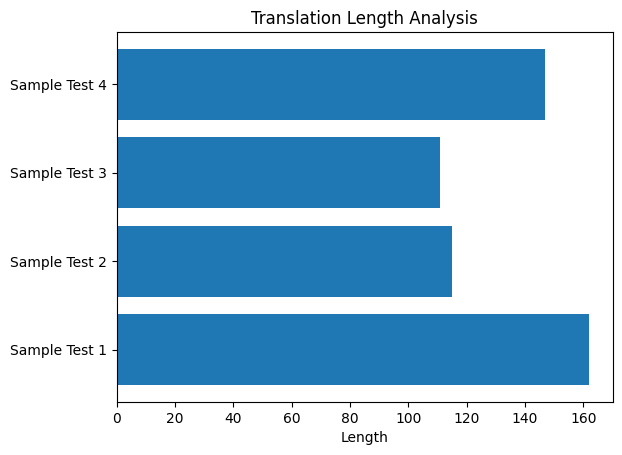

In [126]:
# Result Analysis and Visualization
def plot_results(results):
    plt.barh(range(len(results)), [len(r["translation"]) for r in results], align="center")
    plt.yticks(range(len(results)), [f"Sample Test {i+1}" for i in range(len(results))])
    plt.title("Translation Length Analysis")
    plt.xlabel("Length")
    plt.show()

plot_results(results)


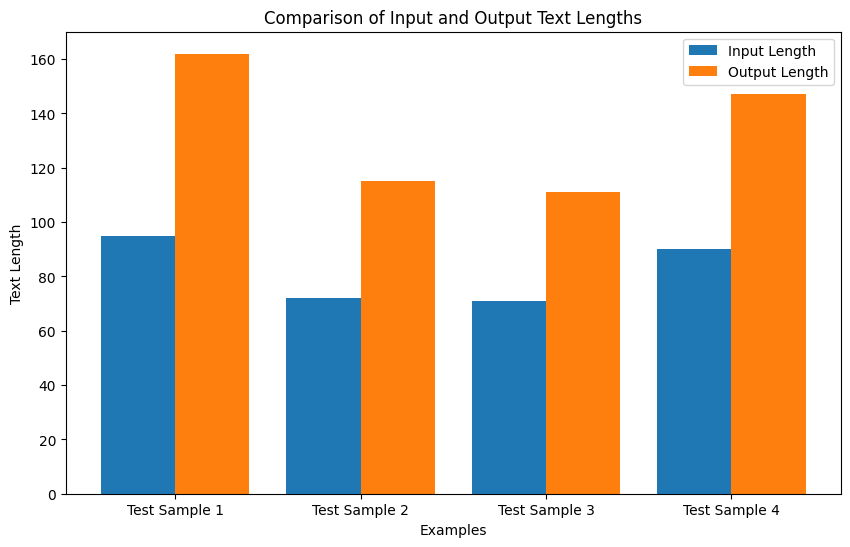

In [128]:
# Result Analysis and Enhanced Visualization
import numpy as np
import seaborn as sns

# 1. Translation Length Comparison
def plot_length_comparison(results):
    input_lengths = [len(res["example"]) for res in results]
    output_lengths = [len(res["translation"]) for res in results]

    plt.figure(figsize=(10, 6))
    x = np.arange(len(results))
    plt.bar(x - 0.2, input_lengths, width=0.4, label="Input Length")
    plt.bar(x + 0.2, output_lengths, width=0.4, label="Output Length")
    plt.xticks(x, [f"Test Sample {i+1}" for i in range(len(results))])
    plt.xlabel("Examples")
    plt.ylabel("Text Length")
    plt.title("Comparison of Input and Output Text Lengths")
    plt.legend()
    plt.show()

plot_length_comparison(results)

In [171]:
# Save model and tokenizer
mdl.save_pretrained("gemma.ckpt")
tok.save_pretrained("gemma_tokenizer.model")

('gemma_tokenizer.model/tokenizer_config.json',
 'gemma_tokenizer.model/special_tokens_map.json',
 'gemma_tokenizer.model/tokenizer.json')

In [172]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the model and tokenizer
model_path = "gemma.ckpt"  # Path to your trained model
tokenizer_path = "gemma_tokenizer.model"  # Path to your tokenizer

# Load model and tokenizer
device = "cuda:0"  # Use CUDA if available
mdl = AutoModelForCausalLM.from_pretrained(model_path).to(device)
tok = AutoTokenizer.from_pretrained(tokenizer_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [174]:

test = [
    "translate the following telugu to english: మీరు ఎలా ఉన్నారు?",
]

# Store results
results = []

# Iterate over test examples
for i, text in enumerate(test, 1):
    # Tokenize the input text
    inputs = tok(text, return_tensors="pt", truncation=True).to(device)

    # Generate text using the model
    outputs = mdl.generate(**inputs, max_new_tokens=50, do_sample=True, top_p=0.9, temperature=0.7)

    # Decode the generated tokens to get the translated text
    translated_text = tok.decode(outputs[0], skip_special_tokens=True)

    # Append to results
    results.append({"example": text, "translation": translated_text})

    # Print the input and translated output
    print(f"Sample Test {i}:")
    print(f"Input: {text}")
    print(f"Output: {translated_text}\n")

Sample Test 1:
Input: translate the following telugu to english: మీరు ఎలా ఉన్నారు?
Output: translate the following telugu to english: మీరు ఎలా ఉన్నారు? | english: how are you? 

